In [20]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
%matplotlib inline

In [21]:
data_train = pd.read_csv("data_train.csv")

In [22]:
data_train.head()

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,...,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,atom_1_C,atom_1_H,atom_1_N
0,0,dsgdb9nsd_000001,1,0,84.8076,0.002150,-0.006031,0.001976,-0.012698,1.085804,...,0,0,0,0,0,0,0,1,0,0
1,1,dsgdb9nsd_000001,1,2,-11.2570,0.002150,-0.006031,0.001976,1.011731,1.463751,...,0,0,1,0,0,0,0,0,1,0
2,2,dsgdb9nsd_000001,1,3,-11.2548,0.002150,-0.006031,0.001976,-0.540815,1.447527,...,0,0,1,0,0,0,0,0,1,0
3,3,dsgdb9nsd_000001,1,4,-11.2543,0.002150,-0.006031,0.001976,-0.523814,1.437933,...,0,0,1,0,0,0,0,0,1,0
4,4,dsgdb9nsd_000001,2,0,84.8074,1.011731,1.463751,0.000277,-0.012698,1.085804,...,0,0,0,0,0,0,0,1,0,0


In [23]:
data_test = pd.read_csv("data_test.csv")
data_test.head()

,id,molecule_name,atom_index_0,atom_index_1,x_0,y_0,z_0,x_1,y_1,z_1,...,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,atom_1_C,atom_1_H,atom_1_N
0,4658147,dsgdb9nsd_000004,2,0,-1.661639,0.0,1.0,0.599539,0.0,1.0,...,0,1,0,0,0,0,0,1,0,0
1,4658148,dsgdb9nsd_000004,2,1,-1.661639,0.0,1.0,-0.599539,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,4658149,dsgdb9nsd_000004,2,3,-1.661639,0.0,1.0,1.661639,0.0,1.0,...,0,0,0,0,0,1,0,0,1,0
3,4658150,dsgdb9nsd_000004,3,0,1.661639,0.0,1.0,0.599539,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,4658151,dsgdb9nsd_000004,3,1,1.661639,0.0,1.0,-0.599539,0.0,1.0,...,0,1,0,0,0,0,0,1,0,0


In [24]:
print(data_test.shape)

(2505542, 26)


In [25]:
print(data_train.shape)

(4658147, 55)


In [26]:
from keras import backend as K
from keras.losses import mean_absolute_error
import tensorflow as tf

In [27]:
print(tf.__version__)

1.3.0


In [28]:
def logloss(y_true, y_pred):
    return tf.log(mean_absolute_error(y_true,y_pred))

In [29]:
features = set(data_train.columns).intersection(set(data_test.columns))
targets = set(data_train.columns).difference(set(data_test.columns))
features.remove('id')
features.remove('molecule_name')
features.remove('atom_index_1')
features.remove('atom_index_0')
print(features, len(features), len(data_test.columns))
print(targets, len(targets))

{'atom_1_C', 'x_diff', 'x_0', 'type_2JHH', 'num_atoms', 'y_diff', 'type_1JHC', 'atom_1_N', 'type_3JHN', 'atom_1_H', 'type_2JHC', 'x_1', 'y_1', 'y_0', 'type_3JHC', 'dist', 'type_3JHH', 'z_0', 'type_1JHN', 'z_diff', 'type_2JHN', 'z_1'} 22 26
{'fc', 'dipole_moment_x', 'XY_0', 'pso', 'ZY_0', 'dso', 'XX_1', 'YY_0', 'dipole_moment_z', 'YY_1', 'YZ_0', 'mulliken_charge_1', 'ZZ_0', 'sd', 'YZ_1', 'XY_1', 'scalar_coupling_constant', 'XX_0', 'ZZ_1', 'potential_energy', 'XZ_1', 'YX_0', 'ZX_0', 'XZ_0', 'dipole_moment_y', 'ZX_1', 'YX_1', 'mulliken_charge_0', 'ZY_1'} 29


In [30]:
data_features = data_train[list(features)]
data_targets = data_train[list(targets)]

In [31]:
all_inputs = pd.concat([data_feautures, data_test[list(features)]])
input_data = StandardScaler().fit_transform(all_inputs)
input_data = pd.DataFrame(input_data, index=all_inputs.index, columns=all_inputs.columns)

NameError: name 'data_feautures' is not defined

In [ ]:
attractors = pd.concat([data_targets, data_test[list(targets)]]).drop('scalar_coupling_constant', axis=1)
output_data = StandardScaler().fit_transform(attractors)
output_data = pd.DataFrame(output_data, index=attractors.index, columns=attractors.columns)
output_data['scalar_coupling_constant'] = pd.concat([data_targets['scalar_coupling_constant'], data_test['scalar_coupling_constant']])

In [15]:
input_data.head()

,atom_1_C,x_diff,x_0,type_2JHH,num_atoms,y_diff,type_1JHC,atom_1_N,type_3JHN,atom_1_H,...,y_1,y_0,type_3JHC,dist,type_3JHH,z_0,type_1JHN,z_diff,type_2JHN,z_1
0,0.621418,-0.004664,-0.058940,-0.297193,-5.062494,0.851495,2.359273,-0.275689,-0.192482,-0.512388,...,0.838296,0.101017,-0.692694,-1.722482,-0.381053,-0.028861,-0.096936,-0.017782,-0.162091,-0.055483
1,-1.609224,0.725628,-0.058940,3.364813,-5.062494,1.105477,-0.423859,-0.275689,-0.192482,1.951646,...,1.052165,0.101017,-0.692694,-0.784301,-0.381053,-0.028861,-0.096936,-0.023382,-0.162091,-0.061633
2,-1.609224,-0.381146,-0.058940,3.364813,-5.062494,1.094574,-0.423859,-0.275689,-0.192482,1.951646,...,1.042984,0.101017,-0.692694,-0.784264,-0.381053,-0.028861,-0.096936,-0.659094,-0.162091,-0.759868
3,-1.609224,-0.369026,-0.058940,3.364813,-5.062494,1.088127,-0.423859,-0.275689,-0.192482,1.951646,...,1.037555,0.101017,-0.692694,-0.784251,-0.381053,-0.028861,-0.096936,0.633499,-0.162091,0.659852
4,0.621418,-0.724370,0.514726,-0.297193,-5.062494,-0.136206,2.359273,-0.275689,-0.192482,-0.512388,...,0.838296,0.793727,-0.692694,-1.722484,-0.381053,-0.029947,-0.096936,-0.016550,-0.162091,-0.055483


In [16]:
output_data.head()

,fc,dipole_moment_x,XY_0,pso,ZY_0,dso,XX_1,YY_0,dipole_moment_z,YY_1,...,XZ_1,YX_0,ZX_0,XZ_0,dipole_moment_y,ZX_1,YX_1,mulliken_charge_0,ZY_1,scalar_coupling_constant
0,1.956281,0.008861,-0.538167,1.190302,-0.628082,0.543911,1.104354,-0.05429,-0.224683,1.287560,...,-0.001028,-0.510046,1.626071,1.747847,-0.049702,-0.002748,0.002531,0.263942,-0.014925,84.8076
1,-0.776777,0.008861,-0.538167,3.345707,-0.628082,-3.442315,-0.972567,-0.05429,-0.224683,-1.034857,...,-0.213274,-0.510046,1.626071,1.747847,-0.049702,-0.221518,0.051591,0.263942,-0.107775,-11.2570
2,-0.776713,0.008861,-0.538167,3.345882,-0.628082,-3.442606,-0.973381,-0.05429,-0.224683,-0.965034,...,0.064092,-0.510046,1.626071,1.747847,-0.049702,0.064371,0.168119,0.263942,0.083135,-11.2548
3,-0.776695,0.008861,-0.538167,3.345923,-0.628082,-3.442670,-0.974831,-0.05429,-0.224683,-0.962650,...,-0.061383,-0.510046,1.626071,1.747847,-0.049702,-0.064951,-0.162477,0.263942,0.079135,-11.2543
4,1.956275,0.008861,0.521036,1.190289,-0.587046,0.543914,1.104354,-0.06957,-0.224683,1.287560,...,-0.001028,0.491207,-1.673630,-1.796006,-0.049702,-0.002748,0.002531,0.263964,-0.014925,84.8074


Callbacks

In [17]:
# Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
es = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8,verbose=1, mode='auto')
# Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=7, min_lr=1e-6, mode='auto', verbose=1)
# Save the best value of the model for future use
sv_mod = ModelCheckpoint("best_model.hdf5", monitor='val_loss', save_best_only=True, period=1)

In [18]:
vars_in = Input(shape=(len(features),))
x = Dense(256)(vars_in)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)
x = Dropout(0.2)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)
x = Dropout(0.2)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)
x = Dropout(0.2)(x)
vars_out = Dense(len(targets), activation="linear")(x)
model = Model(inputs=vars_in, outputs=vars_out)
model.summary()
model.compile(loss="mae", optimizer='adam')
history = model.fit(np.array(input_data[:len(data_train),:]), np.array(output_data), validation_split=0.2, nb_epoch=5, shuffle=True, batch_size=1024)
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 22)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               5888      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
__________

/usr/lib/python3.4/dist-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 3726517 samples, validate on 931630 samples
Epoch 1/5
3726517/3726517 [==============================] - 110s - loss: 0.7193 - val_loss: 0.6279
Epoch 2/5
3726517/3726517 [==============================] - 107s - loss: 0.6766 - val_loss: 0.6199
Epoch 3/5
3726517/3726517 [==============================] - 107s - loss: 0.6662 - val_loss: 0.6090
Epoch 4/5
3726517/3726517 [==============================] - 107s - loss: 0.6604 - val_loss: 0.6075
Epoch 5/5
3726517/3726517 [==============================] - 107s - loss: 0.6567 - val_loss: 0.6033


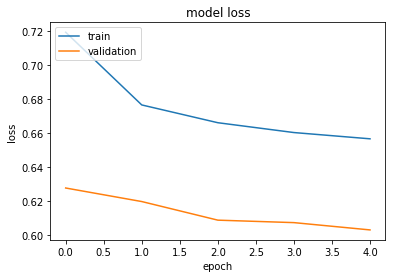

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()